<br>

# Case study: FAO multiplex
## Distance matrices, RBO, and clustering analysis

<br>

<br>

<span style="font-size:1.15em;">

* [1. The FAO dataset](#chapter1)
    * [1.1 Data loading](#section_1_1)
    * [1.2 Graphs creation and partitions](#section_1_2)
    
<br>    

* [2. Distance matrices](#chapter2)

<br>    
    
* [3. Spearman correlation and rank-biased overlap](#chapter3)
    
<br>
    
* [4. Hierarchical clustering](#chapter4)
    
<br>
    
* [Appendix](#chapter5)

</span>
    
<br>

In [1]:
from functions import * # Import the NMI measures, Jensen-Shannon distance, and utilities (NumPy, etc)
import rbo              # Rank-biased overlap (install it via !pip install rbo)

# Import further libraries for data and network analysis
import pandas as pd
import networkx as nx

# Plot settings
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'text.usetex': True}) # LaTeX capabilities 
matplotlib.rcParams.update({'text.latex.preamble': r"", "font.serif": "Times"})
matplotlib.rcParams.update({'font.family':'serif'})
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'svg' # render figures in SVG")
# matplotlib.rcdefaults() # reset matplotlib


<br>

<br>

## 1. The FAO dataset <a class="anchor" id="chapter1"></a>

### 1.1 Data loading <a class="anchor" id="section_1_1"></a>

<br>

Let us load the edge list contained in `edges.csv` as a DataFrame `df_links`. (***All files should be in the same folder.***)



In [2]:
# Edges dataset
names = ['source', 'target', 'weight', 'layer']
df_links = pd.read_csv('edges.csv', sep=',', comment='#', header=None, names=names)
df_links

,source,target,weight,layer
0,0,1,6,3
1,0,13,14,3
2,0,27,1,3
3,0,43,13,3
4,0,44,3,3
...,...,...,...,...
318341,212,16,28,359
318342,212,34,51,359
318343,212,39,295,359
318344,212,21,8,362


The DataFrame above specifies the direction, weight, and the layer of an edge. We thus create below a dictionary containing NetworkX objects (graphs) associated with each layer found in `df_link`. Due to inconsistencies within another dataset (the GDP statistics from the World Bank dataset, see below), it is necessary to remove the following 13 nodes (countries):

```
8	China,_mainland	
9	China,_Taiwan_Province_of	
92	Unspecified	
110	Sudan_(former)	
128	Netherlands_Antilles	
173	Falkland_Islands_(Malvinas)
185	Occupied_Palestinian_Territory	
190	Cook_Islands	
194	Niue	
198	Montserrat	
199	Saint_Pierre_and_Miquelon	
207	Saint_Helena,_Ascension_and_Tristan_da_Cunha	
210	Mayotte
213	Andorra

```

<br>

<br>

### 1.2 Graphs creation and partition <a class="anchor" id="section_1_2"></a>

<br>

In [3]:
# Placeholder for dictionary of graphs
layer_graphs = {}
unique_layers = df_links['layer'].unique()

# Graph creation
num_nodes = df_links['source'].max()
indices_to_remove = [8,9,92,110,128,140,142,155,173,175,185,187,190,194,198,199,200,207,210,213] # problematic countries

for layer in unique_layers:
    layer_edges = df_links[df_links['layer'] == layer][['source', 'target', 'weight']].values
    layer_graph = nx.Graph()
    layer_graph.add_nodes_from(range(num_nodes))
    layer_graph.add_weighted_edges_from(layer_edges)
    layer_graph.remove_nodes_from(indices_to_remove) # remove problematic countries
    layer_graph.remove_edges_from([(u, v) for u, v in layer_graph.edges() if u == v]) # remove self-edges
    layer_graphs[layer] = layer_graph

<br>

Having created and stored the graphs in `layer_graphs`, we can straightforwardly compute the $\text{NMI}$, $\text{DC-NMI}$, and the Jensen-Shannon distance $D_{\text{JS}}$ between them. However, to obtain the analogous mesoscale measure via the $\text{MesoNMI}(B)$ function, we need to build a partition given by a group membership vector $\textbf{b}=(b_1,\dots,b_N)$, where $b_i\leq B$ specifies the group of the $i$-th node. Here, we create partitions for:

<br>

(1) World hemispheres according to the socioeconomic labels of "Global North" and "Global South" ($B=2$);

(2) World continents ($B=6$); 

(3) GDP of countries ranked into 50 divisions ($B=50$).

<br>

The file `df_partition.py` contains the script to generate all the three partitions mentioned above. In what follows, we simply load its output (the CSV file `df_partition.csv`).

In [4]:
names=["index","name","hemisphere","continent","gdp_2010","b_hemis","b_cont","b_gdp"]
df_partition=pd.read_csv("df_partition.csv", sep=',', comment=None, header=0, names=names)
df_partition

,index,name,hemisphere,continent,gdp_2010,b_hemis,b_cont,b_gdp
0,0,Afghanistan,South,Asia,14.362441,0,1,34
1,1,Australia,North,Oceania,2.226538,1,4,16
2,2,Austria,North,Europe,1.837094,1,2,15
3,3,Belgium,North,Europe,2.864293,1,2,17
4,4,Brazil,South,South America,7.528226,0,5,24
...,...,...,...,...,...,...,...,...
190,208,Tuvalu,North,Oceania,-2.222222,1,4,9
191,209,Cayman_Islands,South,South America,-2.715635,0,5,9
192,211,Maldives,South,Asia,6.835471,0,1,23
193,212,Mauritania,South,Africa,2.620230,0,0,16


Finally, the group membership vectors (partitions) are obtained as Numpy arrays (the `[:-1]` is to "ad hocly" remove Andorra).

In [5]:
b_hemis = df_partition.b_hemis.to_numpy()[:-1]
b_cont  = df_partition.b_cont.to_numpy()[:-1]
b_gdp   = df_partition.b_gdp.to_numpy()[:-1]

<br>

<br>

<br>

<br>

## 2. Distance matrices <a class="anchor" id="chapter2"></a>

<br>

The code to compute the distance matrices (NMI, DC-NMI, MesoNMI, and Jensen-Shannon) can be found in the [Appendix](#chapter4). We do not recommend run it because it takes some time to finish (the Jensen-Shannon function relies on solving the spectra of Laplacians). Hence, in the next cell we simply load them as Numpy arrays (their names should be self-explanatory).

In [6]:
M_nmi = np.load("matrix_nmi.npy")
M_dcnmi = np.load("matrix_dcnmi.npy")
M_meso_hemis = np.load("matrix_meso_hemisphere_b2.npy")
M_meso_cont = np.load("matrix_meso_continent_b6.npy")
M_meso_gdp = np.load("matrix_meso_gdp_b50.npy")
M_max = np.load("matrix_meso_bmax.npy")
M_jsd = np.load("matrix_jsd.npy")
M_jsd = np.ones((len(M_jsd),len(M_jsd)))-M_jsd # matrix (1 - JSD) to better compare w/ others

Below we plot the six distance matrices of interest.

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(10,5))
fig.tight_layout()
fig.subplots_adjust(wspace=0.5)
fig.subplots_adjust(hspace=0.75)

# nmi
im1 = axs[0, 0].imshow(M_nmi, cmap='Blues', interpolation='none')
axs[0, 0].set_title('NMI', fontsize=12, pad=10)
fig.colorbar(im1, ax=axs[0, 0])

# dc-nmi
im2 = axs[0, 1].imshow(M_dcnmi, cmap='Blues', interpolation='none')
axs[0, 1].set_title('DC-NMI', fontsize=12, pad=10)
fig.colorbar(im2, ax=axs[0, 1])

# meso B=2
im3 = axs[0, 2].imshow(M_meso_hemis, cmap='Blues', interpolation='none')
axs[0, 2].set_title('MesoNMI \n(hemispheres, $B=2$)', fontsize=12, pad=10)
fig.colorbar(im3, ax=axs[0, 2])

# meso B=6
im4 = axs[1, 0].imshow(M_meso_cont, cmap='Blues', interpolation='none')
axs[1, 0].set_title('MesoNMI \n(continents, $B=6$)', fontsize=12, pad=10)
fig.colorbar(im4, ax=axs[1, 0])

# meso B=50
im5 = axs[1, 1].imshow(M_meso_gdp, cmap='Blues', interpolation='none')
axs[1, 1].set_title('MesoNMI \n(ranked-GDP, $B=50$)', fontsize=12, pad=10)
fig.colorbar(im5, ax=axs[1, 1])

# jensen-shannon
im6 = axs[1, 2].imshow(M_jsd, cmap='Blues', interpolation='none')
axs[1, 2].set_title('Jensen-Shannon distance \n$(1-JSD)$', fontsize=12, pad=10)
fig.colorbar(im6, ax=axs[1,2])

for i in range(2):
    for j in range(3):
        axs[i,j].set_xticks([0, 363])
        axs[i,j].set_xticklabels([1, 364], fontsize=12, rotation=0)
        axs[i,j].set_yticks([0, 363])
        axs[i,j].set_yticklabels([1, 364], fontsize=12, rotation=0)
        axs[i,j].set_xlabel('Layer', fontsize=12, labelpad=-5)
        axs[i,j].set_ylabel('Layer', fontsize=12, labelpad=-10);

<br>

<br>

## Spearman correlation and rank-biased overlap <a class="anchor" id="chapter3"></a>

<br>

Here we compute two 6x6 matrices comparing the six different methods of measuring similarity (distances) between graphs. The first is the common Spearman rank correlation, while the second is known as the rank-biased overlap (RBO). In RBO, we take into account the weights of the ranked elements in a list. The procedure can be summarized a follows: given a vector $\textbf{v}=[v_1, v_2, \dots, v_N]$, we assign to it an index vector $I_{\textbf{v}}=[1, 2, \dots, N]$ to obtain its ranked counterpart 

$$\text{rank}(I_{\textbf{v}})=[i, j, \dots, k] ~,$$

where $i>j>\dots>k$. The similarity between two vectors $\textbf{v}$ and $\textbf{u}$ is thus based on the set-theoretic intersection between their associated ranked index vectors $\text{rank}(I_{\textbf{v}})$ and $\text{rank}(I_{\textbf{u}})$, respectively.

Let us compute the Spearman correlation between distance matrices, as well as their RBO.

In [8]:
from scipy.stats import spearmanr

X = [M_nmi, M_dcnmi, M_meso_hemis, M_meso_cont, M_meso_gdp, M_max, M_jsd]
X_flattened = [x.flatten() for x in X] # flatten to get vectors

n=len(X)
P_spearman=np.zeros((n,n))
for i in range(len(X)):
    for j in range(i, len(X)):
        P_spearman[i,j], _ = spearmanr(X_flattened[i], X_flattened[j])
        P_spearman[j,i]    = P_spearman[i,j]

P_rbo=np.zeros((n,n))
for i in range(len(X)):
    for j in range(i, len(X)):
        Xi,Xj = X_flattened[i], X_flattened[j]
        Xi,Xj = sorted(np.arange(len(Xi)), key=lambda i: Xi[i], reverse=True), sorted(np.arange(len(Xj)), key=lambda i: Xj[i], reverse=True)
        P_rbo[i,j] = rbo.RankingSimilarity(Xi, Xj).rbo()
        P_rbo[j,i] = P_rbo[i,j]

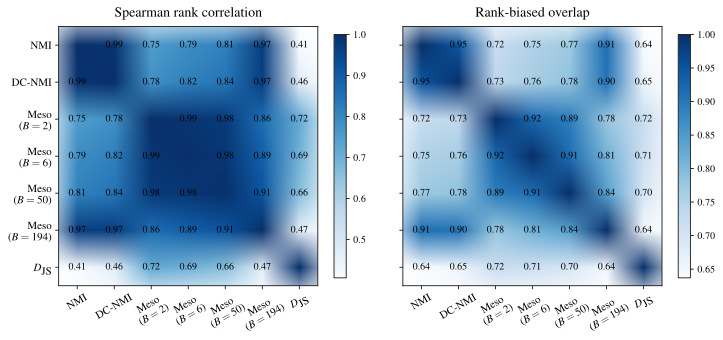

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12,8))
fig.subplots_adjust(wspace=0.0625)

# Plot 1: Spearman rank correlation
im1 = axs[0].imshow(P_spearman, cmap='Blues', interpolation='none')
axs[0].set_title('Spearman rank correlation', fontsize=14, pad=10)
axs[0].set_xticks(ticks=[0, 1, 2, 3, 4, 5, 6])
axs[0].set_xticklabels(['NMI', 'DC-NMI', 'Meso \n($B=2$)', 'Meso \n($B=6$)', 'Meso \n($B=50$)', 'Meso \n($B=194$)', '$D_{\\textrm{JS}}$'], rotation=30, fontsize=11)
axs[0].set_yticks(ticks=[0, 1, 2, 3, 4, 5, 6])
axs[0].set_yticklabels(['NMI', 'DC-NMI', 'Meso \n($B=2$)', 'Meso \n($B=6$)', 'Meso \n($B=50$)', 'Meso \n($B=194$)', '$D_{\\textrm{JS}}$'], fontsize=11)
for i in range(len(P_spearman)):
    for j in range(len(P_spearman[0])):
        if i != j:
            text_color = 'black' if np.mean(plt.cm.viridis(P_spearman[i, j])[:3]) > 0.5 else 'black'
            axs[0].text(j, i, f'{P_spearman[i, j]:.2f}', ha='center', va='center', color=text_color)
fig.colorbar(im1, ax=axs[0], shrink=0.55)

# Plot 2: Rank-biased overlap
im2 = axs[1].imshow(P_rbo, cmap='Blues', interpolation='none')
axs[1].set_title('Rank-biased overlap', fontsize=14, pad=10)
axs[1].set_xticks(ticks=[0, 1, 2, 3, 4, 5, 6])
axs[1].set_xticklabels(['NMI', 'DC-NMI', 'Meso \n($B=2$)', 'Meso \n($B=6$)', 'Meso \n($B=50$)', 'Meso \n($B=194$)', '$D_{\\textrm{JS}}$'], rotation=30, fontsize=11)
axs[1].set_yticks(ticks=[0, 1, 2, 3, 4, 5, 6])
axs[1].set_yticklabels([], fontsize=11)
for i in range(len(P_rbo)):
    for j in range(len(P_rbo[0])):
        if i != j:
            text_color = 'black' if np.mean(plt.cm.viridis(P_rbo[i, j])[:3]) < 0.9 else 'black'
            axs[1].text(j, i, f'{P_rbo[i, j]:.2f}', ha='center', va='center', color=text_color)
fig.colorbar(im2, ax=axs[1], shrink=0.55);

<br>

<br>

<br>

<br>

## Hierarchical clustering analysis <a class="anchor" id="chapter4"></a>

<br>

Here we perform hierarchical clustering analysis over the distance matrices obtained previously. In the plot below, we show the number of clusters against the linkage distance for each one of the distance matrices. The measures are ordered roughly by their scale of interest, with measures operating at similar scales having similar linkage patterns.

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage

def min_nonzero(X):
    return [x for x in X if x != 0]

def normalize_list(lst):
    max_val = max(lst)
    if max_val != 0:
        normalized_lst = [x / max_val for x in lst]
    else:
        normalized_lst = lst
    return normalized_lst

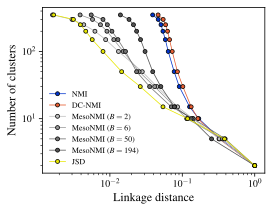

In [11]:
lw=0.75
colors = ['#0033cc','#e55c30','#009933', '#bdbdbd', '#969696', '#737373']

fig, axs = plt.subplots(1, 1, figsize=(4, 3))

X = [M_nmi, M_dcnmi, M_meso_hemis, M_meso_cont, M_meso_gdp, M_max, M_jsd]

# placeholder for linkage distances and number of clusters
linkage_distances_list = []
num_clusters_list = []

for M in X:
    Z = linkage(M, method='ward')
    linkage_distances = []
    num_clusters = []
    for k in [2, 5, 10, 15, 30, 50, 100, 150, 200, 250, 300, 350]:
        dendro = dendrogram(Z, truncate_mode='lastp', p=k, no_plot=True) # cut dendogram at k clusters
        linkage_distance=min(min_nonzero(min(dendro['dcoord'])))
        linkage_distances.append(linkage_distance)
        num_clusters.append(k)
    linkage_distances_list.append(linkage_distances)
    num_clusters_list.append(num_clusters)

X_names=['NMI', 'DC-NMI', 'MesoNMI ($B=2$)', 'MesoNMI ($B=6$)', 'MesoNMI ($B=50$)', 'MesoNMI ($B=194$)', 'JSD']
grays=[_, _, '#bdbdbd', '#969696', '#737373', '#525252']

norm_dists_list = [normalize_list(lst) for lst in linkage_distances_list]

for i, (linkage_distances, num_clusters) in enumerate(zip(norm_dists_list, num_clusters_list)):
    label = X_names[i]
    if i in [2,3,4,5]:
        axs.plot(linkage_distances, num_clusters, marker='o', markersize=4, mec='k', mew=0.75, ls='-', lw=lw, label=label, color=grays[i])
    elif i==0:
        axs.plot(linkage_distances, num_clusters, marker='o', markersize=4, mec='k', mew=0.75, ls='-', lw=lw, label=label,color=colors[i])
    elif i==1:
        axs.plot(linkage_distances, num_clusters, marker='o', markersize=4, mec='k', mew=0.75, ls='-', lw=lw, label=label,color=colors[i])
    else:
        axs.plot(linkage_distances, num_clusters, marker='o', markersize=4, mec='k', mew=0.75, ls='-', lw=lw, label=label,color='#e6e600')

axs.set_ylabel('Number of clusters', fontsize=12)
axs.set_xlabel('Linkage distance', fontsize=12)

axs.set_yscale("log")
axs.set_xscale("log")

axs.legend(frameon=False, fontsize=8);

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

## Appendix <a class="anchor" id="chapter5"></a>

<br>

For completeness, we put here the code to compute the distance matrices. (There's an intentional syntax error so as to not accidentally run this cell, since it takes a few hours to finish.)

In [ ]:
print("This cell take hours to finalize. Run with conscience"

"""
    extra functions (JSD)
"""
def comb_laplacian(g):
    """combinatorial laplacian graph according to manlio's 2015"""
    K=g.number_of_nodes()
    L=nx.laplacian_matrix(g,weight=None).toarray()
    return L / (2*K)

def vne_ent(rho):
    """von neumann entropy according to braunstein (2006, see sec 3.1 arxiv.org/abs/quant-ph/0406165)"""
    eigs=np.linalg.eigvals(rho)
    return -sum(x*zero_log(x) for x in eigs) / np.log2(len(eigs) - 1)

def d_jensen_shannon(g1, g2):
    """jensen-shannon distance between graphs (see manlio 2015)"""
    rho,sigma=comb_laplacian(g1),comb_laplacian(g2)
    mu=.5*(rho + sigma)
    return vne_ent(mu)-.5*(vne_ent(rho)+vne_ent(sigma))

# nmi
n=layer_graphs[1].number_of_nodes()
N=len(layer_graphs)
M=np.zeros((N,N))
for i in range(1, N+1):
    for j in range(i, N+1):
        M[i-1,j-1]=graphNMI(set(layer_graphs[i].edges()),set(layer_graphs[j].edges()),n)
        M[j-1,i-1]=M[i-1,j-1]
        M[i-1,i-1]=1
np.save('matrix_nmi.npy', M)

# dcnmi
n=layer_graphs[1].number_of_nodes()
N=len(layer_graphs)
M=np.zeros((N,N))
for i in range(1, N+1):
    for j in range(i, N+1):
        gi,gj=nx.convert_node_labels_to_integers(layer_graphs[i], first_label=0),nx.convert_node_labels_to_integers(layer_graphs[j], first_label=0)
        M[i-1,j-1]=graphDCNMI(set(gi.edges()),set(gj.edges()),n)
        M[j-1,i-1]=M[i-1,j-1]
        M[i-1,i-1]=1
np.save('matrix_dcnmi.npy', M)

print("starting computation of mesoB2")

# meso B=2 (hemis)
n=layer_graphs[1].number_of_nodes()
N=len(layer_graphs)
M=np.zeros((N,N))
for i in range(1, N+1):
    for j in range(i, N+1):
        gi,gj=nx.convert_node_labels_to_integers(layer_graphs[i], first_label=0, ordering='sorted'),nx.convert_node_labels_to_integers(layer_graphs[j], first_label=0, ordering='sorted')
        M[i-1,j-1]=mesoNMI(n, set(gi.edges()), set(gj.edges()), b_hemis)
        M[j-1,i-1]=M[i-1,j-1]
        M[i-1,i-1]=1
np.save('matrix_meso_hemisphere_b2.npy', M)

# meso B=6 (continent)
n=layer_graphs[1].number_of_nodes()
N=len(layer_graphs)
M=np.zeros((N,N))
for i in range(1, N+1):
    for j in range(i, N+1):
        gi,gj=nx.convert_node_labels_to_integers(layer_graphs[i], first_label=0, ordering='sorted'),nx.convert_node_labels_to_integers(layer_graphs[j], first_label=0, ordering='sorted')
        M[i-1,j-1]=mesoNMI(n, set(gi.edges()), set(gj.edges()), b_cont)
        M[j-1,i-1]=M[i-1,j-1]
        M[i-1,i-1]=1
np.save('matrix_meso_continent_b6.npy', M)

# meso B=50 (gdp)
n=layer_graphs[1].number_of_nodes()
N=len(layer_graphs)
M=np.zeros((N,N))
for i in range(1, N+1):
    for j in range(i, N+1):
        gi,gj=nx.convert_node_labels_to_integers(layer_graphs[i], first_label=0, ordering='sorted'),nx.convert_node_labels_to_integers(layer_graphs[j], first_label=0, ordering='sorted')
        M[i-1,j-1]=mesoNMI(n, set(gi.edges()), set(gj.edges()), b_gdp)
        M[j-1,i-1]=M[i-1,j-1]
        M[i-1,i-1]=1
np.save('matrix_meso_gdp_b50.npy', M)

print("starting computation of mesoBmax")

# meso B=194 (all countries)
n=layer_graphs[1].number_of_nodes()
b_max=np.arange(0, n)
N=len(layer_graphs)
M=np.zeros((N,N))
for i in range(1, N+1):
    for j in range(i, N+1):
        gi,gj=nx.convert_node_labels_to_integers(layer_graphs[i], first_label=0, ordering='sorted'),nx.convert_node_labels_to_integers(layer_graphs[j], first_label=0, ordering='sorted')
        M[i-1,j-1]=mesoNMI(n, set(gi.edges()), set(gj.edges()), b_max)
        M[j-1,i-1]=M[i-1,j-1]
        M[i-1,i-1]=1
np.save('matrix_meso_bmax.npy', M)

# JSD
n=layer_graphs[1].number_of_nodes()
N=len(layer_graphs)
M=np.zeros((N,N))
for i in range(1, N+1):
    for j in range(i, N+1):
        M[i-1,j-1]=d_jensen_shannon(layer_graphs[i],layer_graphs[j])
        M[j-1,i-1]=M[i-1,j-1]
        M[i-1,i-1]=0
np.save('matrix_jsd.npy', M)


<br>

<br>

<br>
<br>

<br>

<br>
<br>

<br>

<br>
<br>

<br>

<br>
<br>

<br>

<br>
